<div class="alert alert-block alert-info">

<h1 style="font-family:verdana;"> Description:</h1>

<ul>
<li><p style="font-family:verdana;">
In this notebook, we are going to predict the purchasing amount of customers during Black Friday, using various features such as age, gender, marital status.
</p></li>
    
<li><p style="font-family:verdana;">
The dataset we are going to use is the Black Friday dataset from Kaggle which contains about 550068 rows and 12 features that can be downloaded <a href="https://www.kaggle.com/sdolezel/black-friday">here</a>.
</p></li>

<li><p style="font-family:verdana;">
The dataset contains the labels which we have to predict and the labels are continuous. So the problem we have is a Supervised Regression type.
</p></li>  
</ul>

</div>

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


## Step 0: Import libraries and dataset

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import datetime as dt
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from google.cloud import bigquery
import warnings
import missingno as msno
warnings.filterwarnings('ignore')

In [3]:
%%bigquery train
SELECT *
FROM demoespecialidadgcp.demo_2_black_friday.raw_train;

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
%%bigquery test
SELECT *
FROM demoespecialidadgcp.demo_2_black_friday.raw_test;

Query is running:   0%|          |

Downloading:   0%|          |

## Step 1: Descriptive analysis

In [5]:
# Preview training dataset
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1003521,P00350942,M,26-35,0,B,3,0,3,4,5,10718
1,1003521,P00117442,M,26-35,0,B,3,0,5,14,<NA>,8643
2,1003521,P00295942,M,26-35,0,B,3,0,2,5,15,13002
3,1003521,P00089442,M,26-35,0,B,3,0,8,<NA>,<NA>,9784
4,1003521,P00086042,M,26-35,0,B,3,0,8,14,17,9764


In [6]:
# Preview testing dataset
test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1003521,P00252542,M,26-35,0,B,3,0,8,<NA>,<NA>
1,1003521,P00221442,M,26-35,0,B,3,0,1,2,5
2,1003521,P00003442,M,26-35,0,B,3,0,4,5,8
3,1003521,P00254342,M,26-35,0,B,3,0,5,11,<NA>
4,1003521,P00233542,M,26-35,0,B,3,0,1,15,<NA>


In [7]:
# Training dataset dimensions - (rows, columns)
print('Training data: \nRows: {} Columns: {}'.format(train.shape[0], train.shape[1]))

Training data: 
Rows: 550068 Columns: 12


In [8]:
# Testing dataset dimensions - (rows, columns)
print('Testing data: \nRows: {} Columns: {}'.format(test.shape[0], test.shape[1]))

Testing data: 
Rows: 233599 Columns: 11


In [9]:
# Features data-type
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  Int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  Int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  Int64 
 8   Product_Category_1          550068 non-null  Int64 
 9   Product_Category_2          376430 non-null  Int64 
 10  Product_Category_3          166821 non-null  Int64 
 11  Purchase                    550068 non-null  Int64 
dtypes: Int64(7), object(5)
memory usage: 54.0+ MB


In [10]:
train["User_ID"] = train["User_ID"].astype(object)
train["Product_Category_1"] = train["Product_Category_1"].astype(object)
train["Product_Category_2"] = train["Product_Category_2"].astype(object)
train["Product_Category_3"] = train["Product_Category_3"].astype(object)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  object
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  Int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  Int64 
 8   Product_Category_1          550068 non-null  object
 9   Product_Category_2          376430 non-null  object
 10  Product_Category_3          166821 non-null  object
 11  Purchase                    550068 non-null  Int64 
dtypes: Int64(3), object(9)
memory usage: 51.9+ MB


In [12]:
# Statistical summary
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Occupation,550068.0,8.076707,6.52266,0.0,2.0,7.0,14.0,20.0
Marital_Status,550068.0,0.409653,0.49177,0.0,0.0,0.0,1.0,1.0
Purchase,550068.0,9263.968713,5023.065394,12.0,5823.0,8047.0,12054.0,23961.0


In [13]:
# Checking for Null values
round((train.isnull().sum() / train.shape[0]) * 100, 2).astype(str) + ' %'

User_ID                         0.0 %
Product_ID                      0.0 %
Gender                          0.0 %
Age                             0.0 %
Occupation                      0.0 %
City_Category                   0.0 %
Stay_In_Current_City_Years      0.0 %
Marital_Status                  0.0 %
Product_Category_1              0.0 %
Product_Category_2            31.57 %
Product_Category_3            69.67 %
Purchase                        0.0 %
dtype: object

<Axes: >

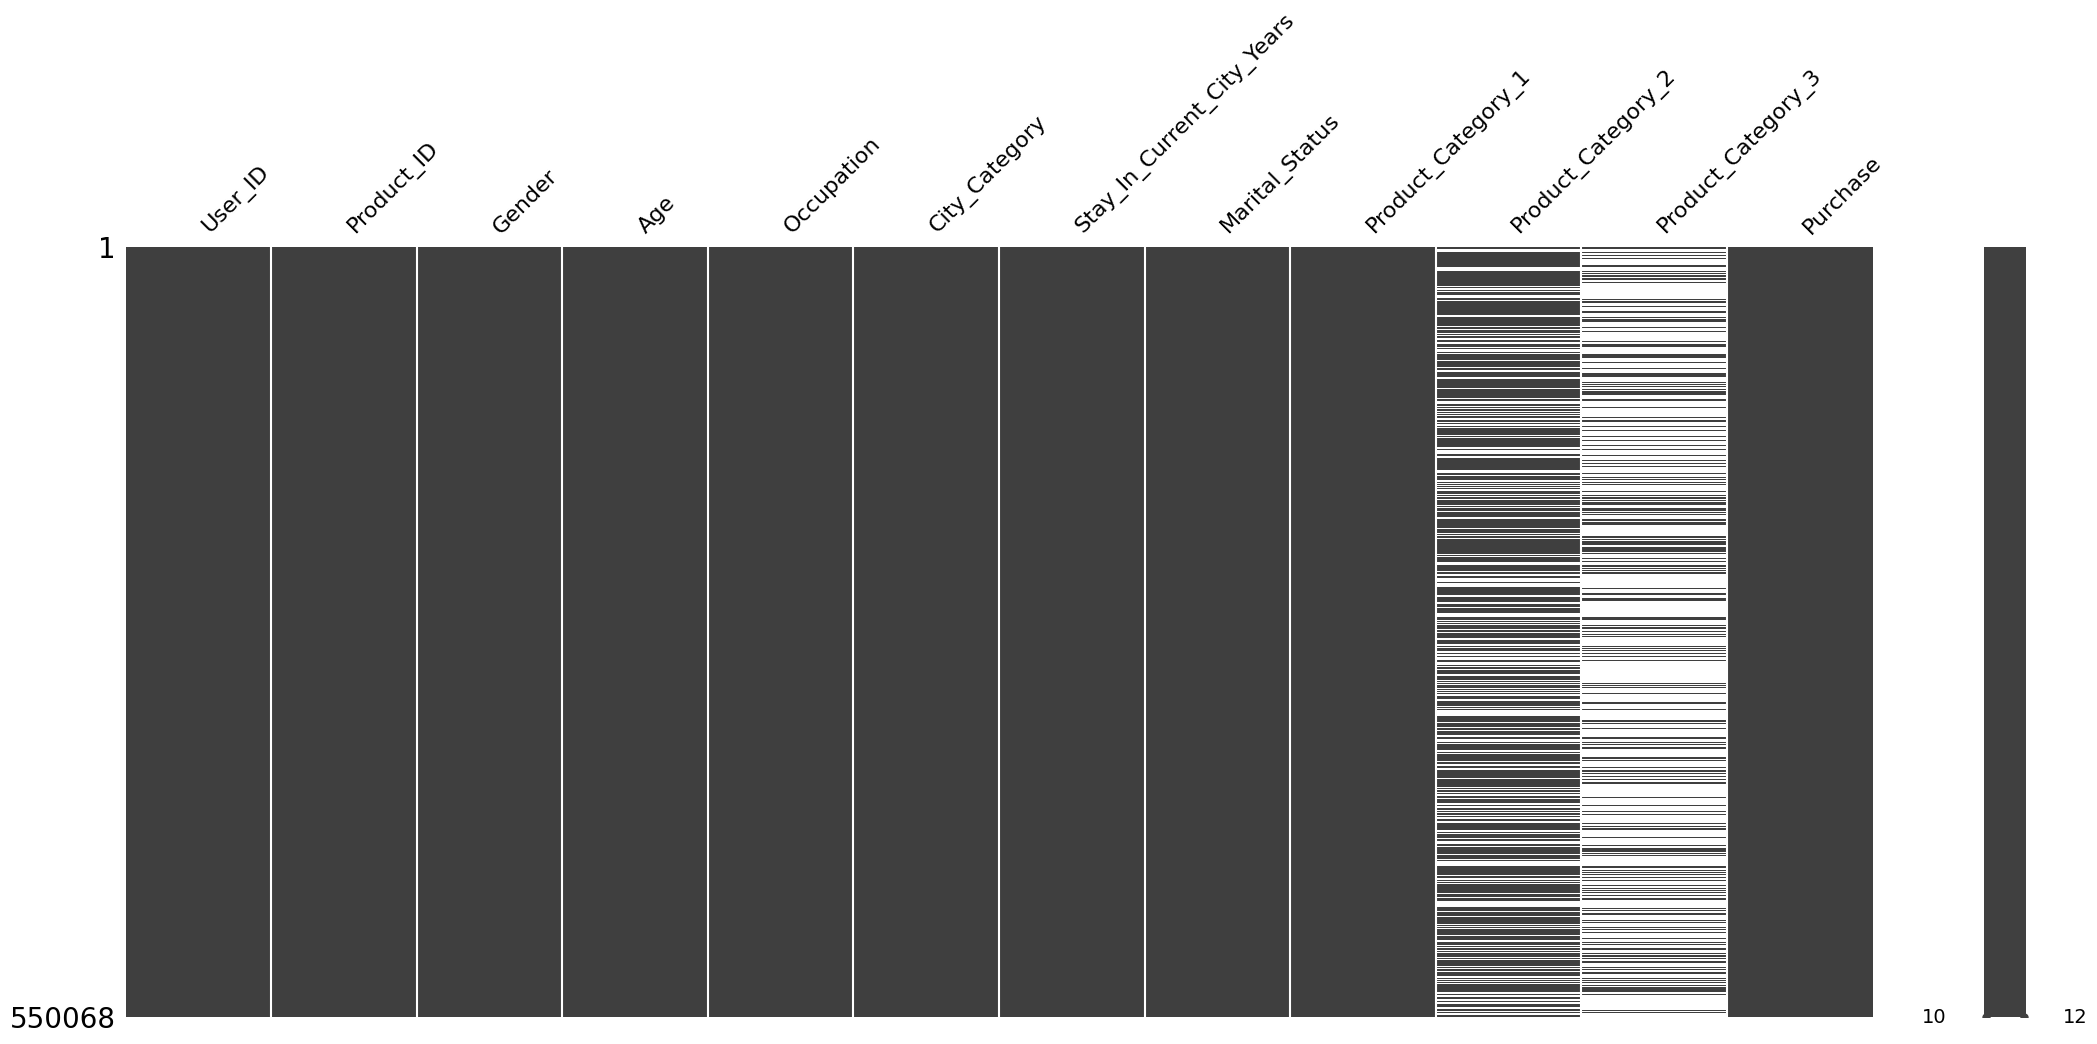

In [14]:
msno.matrix(train)

In [30]:
#Fill the null values of produt_category_2
train['Product_Category_2'] = train['Product_Category_2'].fillna('Unknown')

<Axes: >

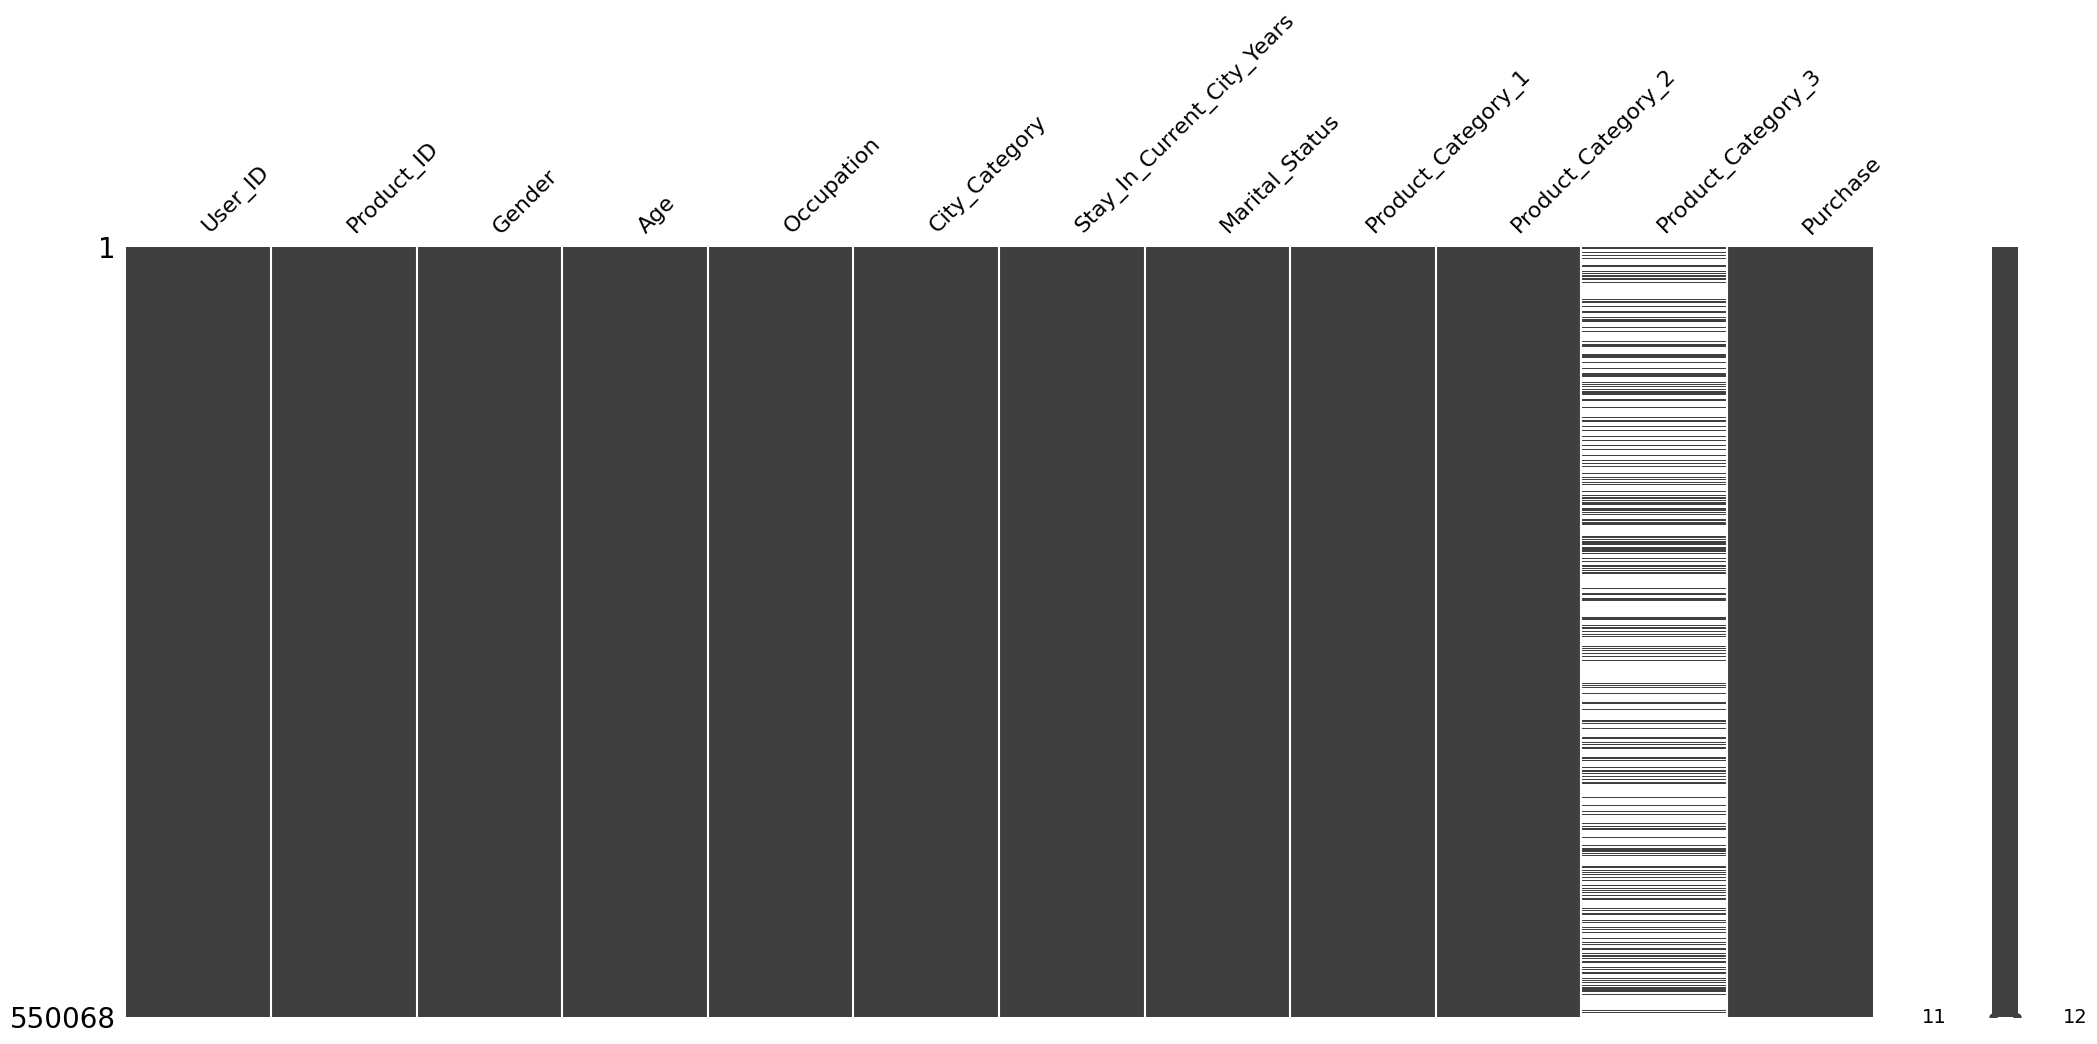

In [31]:
msno.matrix(train)

In [15]:
# Checking the counts of unique values
round((train['Age'].value_counts(normalize = True).mul(100)), 2).astype(str) + ' %'

Age
26-35    39.92 %
36-45     20.0 %
18-25    18.12 %
46-50     8.31 %
51-55      7.0 %
55+       3.91 %
0-17      2.75 %
Name: proportion, dtype: object

In [16]:
# Checking the counts of unique values
round((train['Stay_In_Current_City_Years'].value_counts(normalize = True).mul(100)), 2).astype(str) + ' %'

Stay_In_Current_City_Years
1     35.24 %
2     18.51 %
3     17.32 %
4+     15.4 %
0     13.53 %
Name: proportion, dtype: object

<div class="alert alert-block alert-info">

<h3 style="font-family:verdana;"> Observations:</h3>

<ul>
    
<li><p style="font-family:verdana;">
The feature 'Product_Category_2' contains 31.57% null values which can be imputed whereas 'Product_Category_3' contains 69.67% null values so we can drop this feature.
</p></li>    

<li><p style="font-family:verdana;">
The features 'Age' and 'Stay_In_Current_City_Years' contain some values which have '+' in them which need to be replaced.
</p></li>    

</ul>

</div>

## Step 2: Exploratory Data Analysis

### 2.1 Univariate Analysis

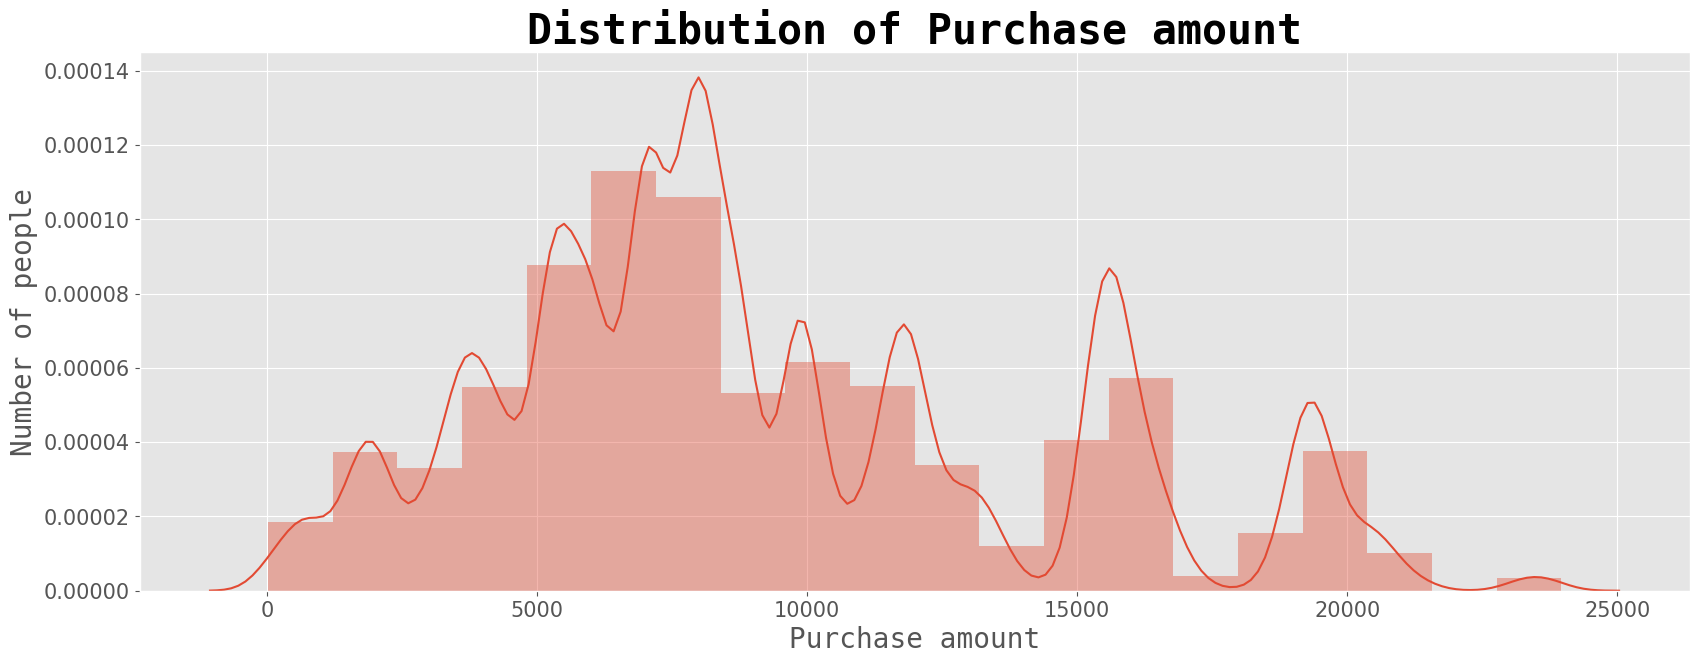

In [17]:
# Creating a distplot for dependent feature 'Purchase'
plt.style.use('ggplot')
plt.figure(figsize = (20, 7))
sns.distplot(train['Purchase'], bins = 20)
plt.title('Distribution of Purchase amount', fontdict = {'fontname' : 'Monospace', 'fontsize' : 30, 'fontweight' : 'bold'})
plt.xlabel('Purchase amount', fontdict = {'fontname' : 'Monospace', 'fontsize' : 20})
plt.ylabel('Number of people', fontdict = {'fontname' : 'Monospace', 'fontsize' : 20})
plt.tick_params(labelsize = 15)
plt.show()

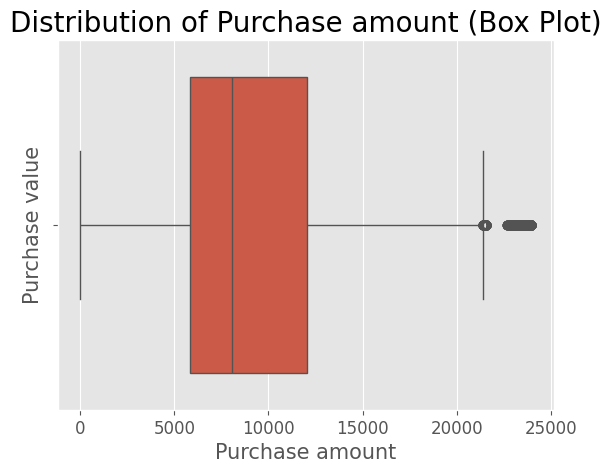

In [18]:
# Create the box plot
sns.boxplot(
    x = train["Purchase"]
)

# Customize the plot
plt.title('Distribution of Purchase amount (Box Plot)', fontdict={'fontsize': 20})
plt.xlabel('Purchase amount', fontdict={'fontsize': 15})
plt.ylabel('Purchase value', fontdict={'fontsize': 15})
plt.tick_params(labelsize=12)
plt.show()

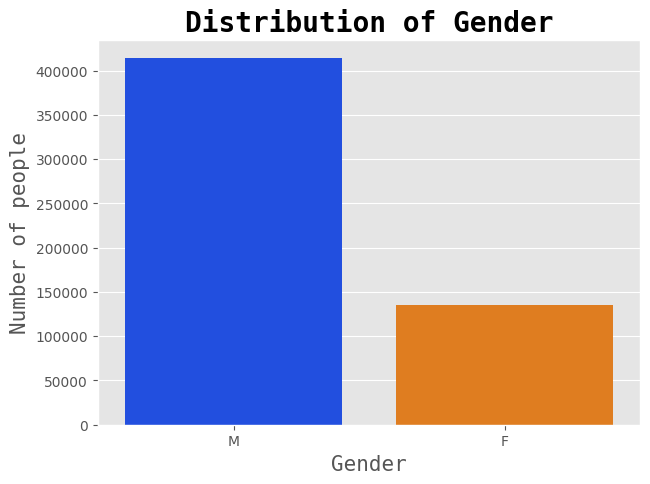

In [19]:
# Creating a barplot for 'Gender'
gen = train['Gender'].value_counts()

plt.figure(figsize = (7, 5))
plt.style.use('ggplot')
sns.barplot(gen, palette = 'bright')
plt.title('Distribution of Gender', fontdict = {'fontname' : 'Monospace', 'fontsize' : 20, 'fontweight' : 'bold'})
plt.xlabel('Gender', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15})
plt.ylabel('Number of people', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15})
plt.tick_params(labelsize = 10)
plt.show()

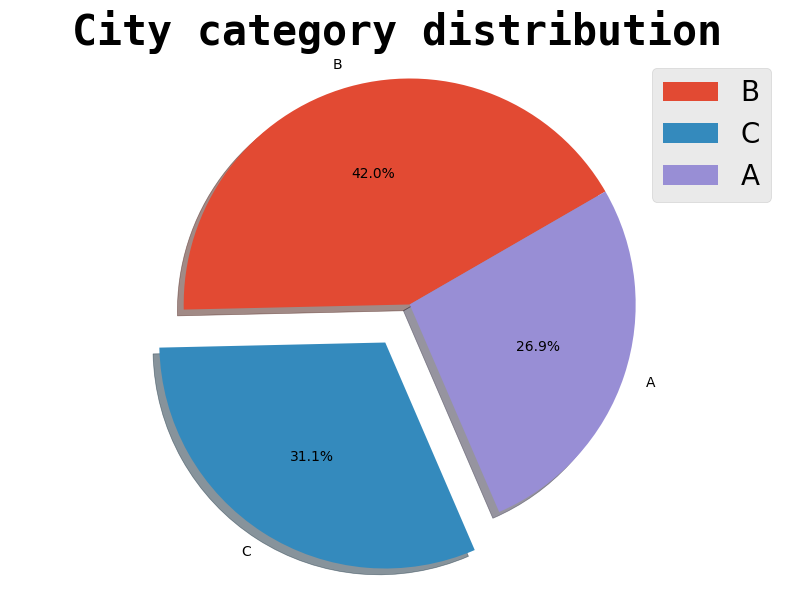

In [20]:
# Creating a pie chart for 'City Category'
city = train['City_Category'].value_counts()

plt.style.use('ggplot')
plt.figure(figsize = (10, 7))
plt.pie(city.values, labels = city.index, startangle = 30, explode = (0 , 0.20, 0), shadow = True, autopct = '%1.1f%%')
plt.title('City category distribution', fontdict = {'fontname' : 'Monospace', 'fontsize' : 30, 'fontweight' : 'bold'})
plt.legend()
plt.legend(prop = {'size' : 20})
plt.axis('equal')
plt.show()

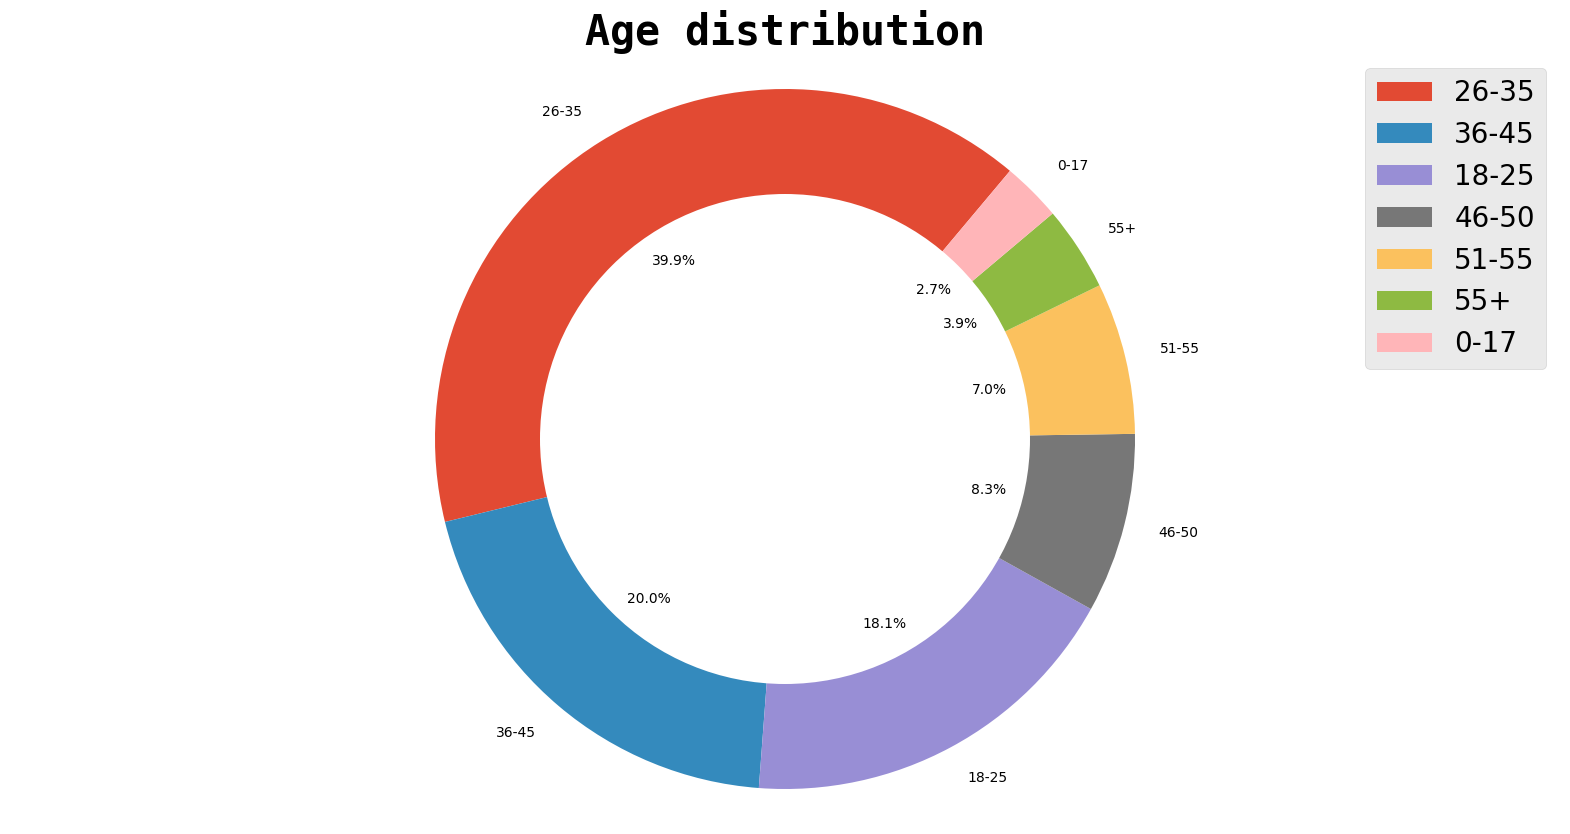

In [21]:
# Creating a donut chart for 'Age'
age = train['Age'].value_counts()

plt.style.use('ggplot')
plt.figure(figsize = (20, 10))
plt.pie(age.values, labels = age.index, startangle = 50, autopct = '%1.1f%%')
centre_circle = plt.Circle((0, 0), 0.7, fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Age distribution', fontdict = {'fontname' : 'Monospace', 'fontsize' : 30, 'fontweight' : 'bold'})
plt.axis('equal')
plt.legend(prop = {'size' : 20})
plt.show()

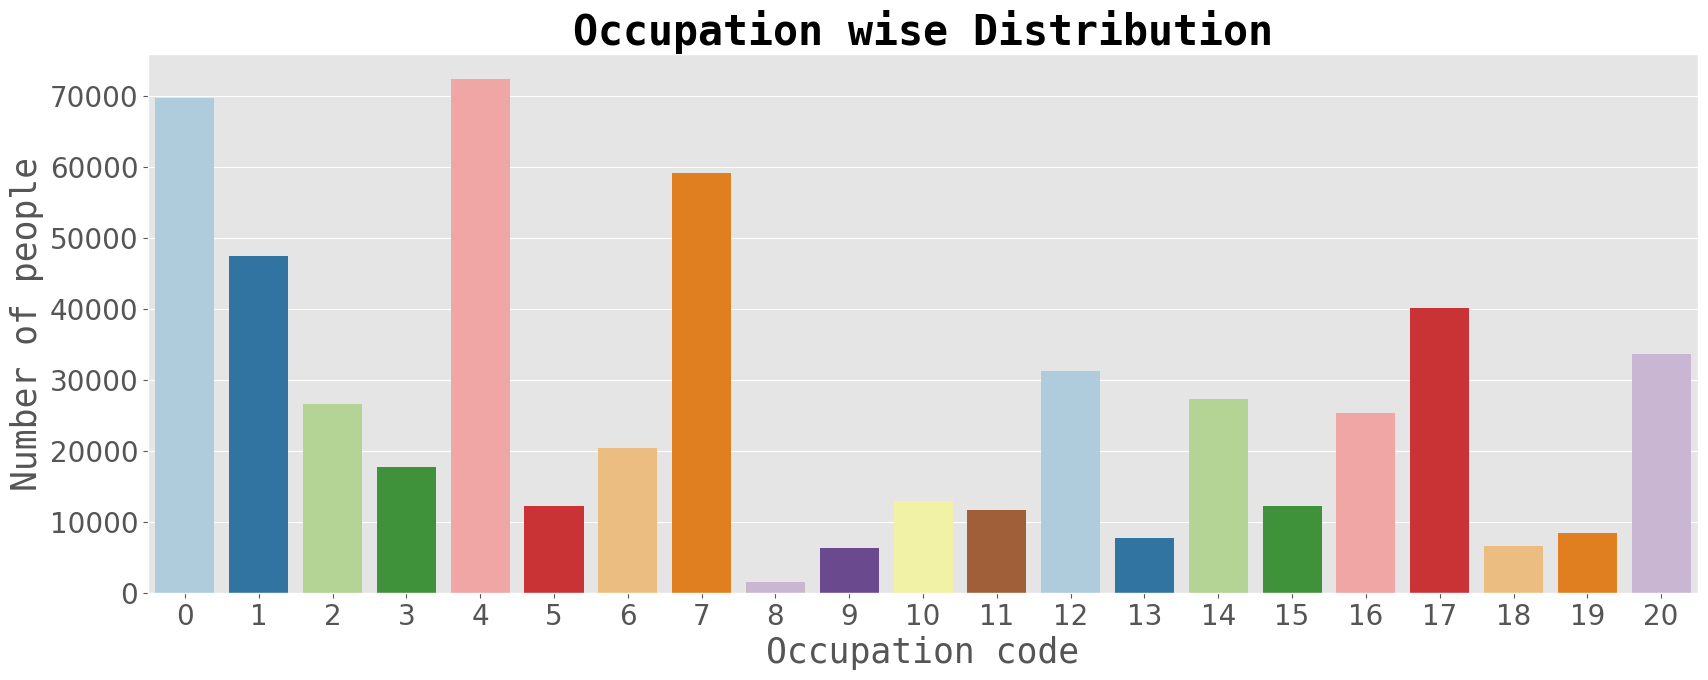

In [22]:
# Creating a barplot for 'Occupation'
occupation = train['Occupation'].value_counts()

plt.figure(figsize = (20, 7))
plt.style.use('ggplot')
sns.barplot(occupation, palette = 'Paired')
plt.title('Occupation wise Distribution', fontdict = {'fontname' : 'Monospace', 'fontsize' : 30, 'fontweight' : 'bold'})
plt.xlabel('Occupation code', fontdict = {'fontname' : 'Monospace', 'fontsize' : 25})
plt.ylabel('Number of people', fontdict = {'fontname' : 'Monospace', 'fontsize' : 25})
plt.tick_params(labelsize = 20)
plt.show()

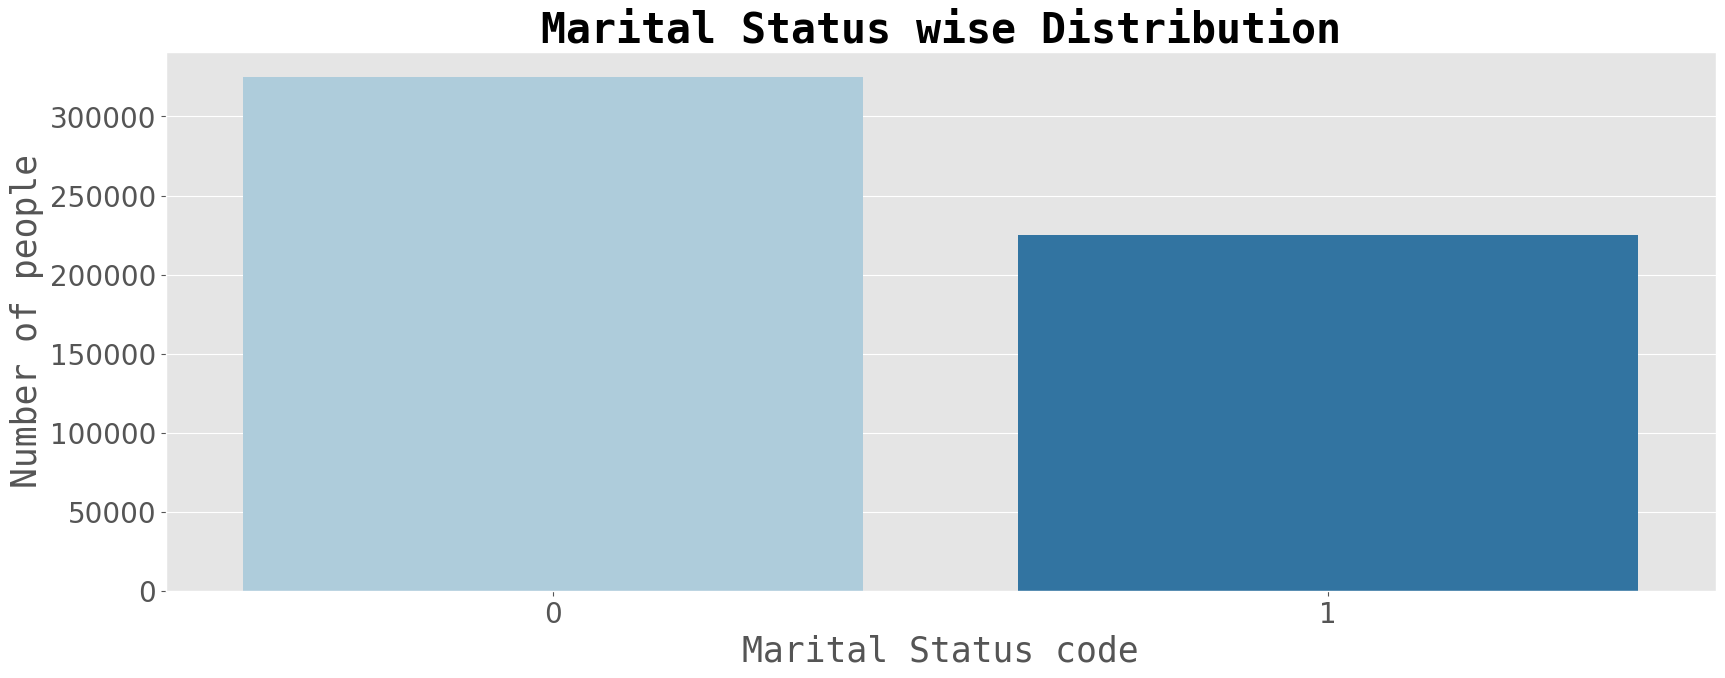

In [26]:
# Creating a barplot for 'Occupation'
occupation = train['Marital_Status'].value_counts()

plt.figure(figsize = (20, 7))
plt.style.use('ggplot')
sns.barplot(occupation, palette = 'Paired')
plt.title('Marital Status wise Distribution', fontdict = {'fontname' : 'Monospace', 'fontsize' : 30, 'fontweight' : 'bold'})
plt.xlabel('Marital Status code', fontdict = {'fontname' : 'Monospace', 'fontsize' : 25})
plt.ylabel('Number of people', fontdict = {'fontname' : 'Monospace', 'fontsize' : 25})
plt.tick_params(labelsize = 20)
plt.show()

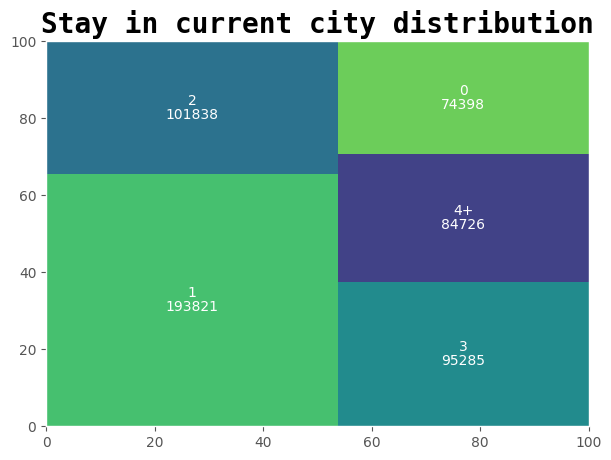

In [27]:
# Creating a Treemap for 'Stay_In_Current_City_Years'
stay = train['Stay_In_Current_City_Years'].value_counts()

import squarify
# plt.style.use('ggplot')
plt.figure(figsize = (7, 5))
squarify.plot(sizes = stay.values, label = stay.index, value = stay.values, text_kwargs={'color':'white'})
plt.title('Stay in current city distribution', fontdict = {'fontname' : 'Monospace', 'fontsize' : 20, 'fontweight' : 'bold'})
plt.show()

### 2.2 Bivariate Analysis

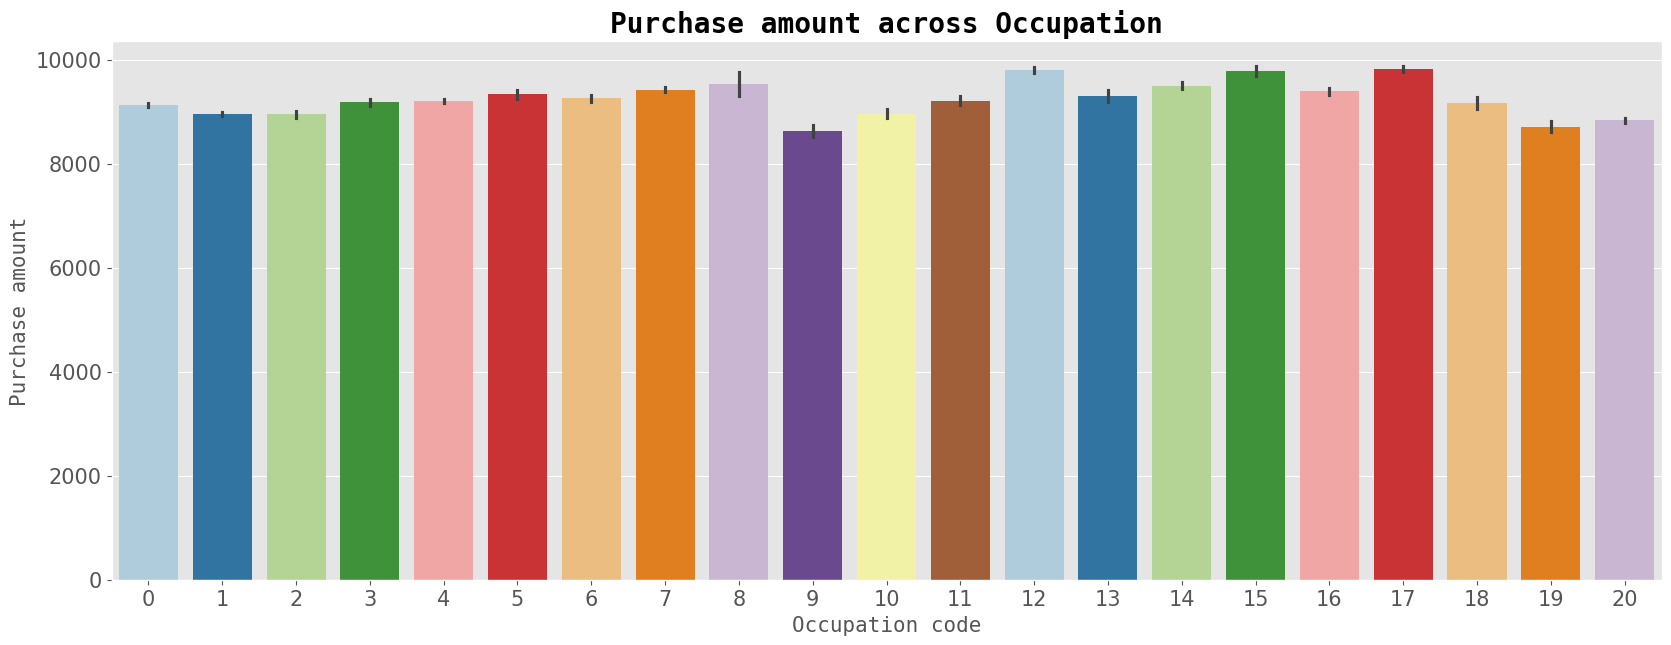

In [28]:
# Creating a barplot of 'Occupation vs Purchase'
plt.figure(figsize = (20, 7))
plt.style.use('ggplot')
sns.barplot(x=train['Occupation'], y=train['Purchase'], palette = 'Paired')
plt.title('Purchase amount across Occupation', fontdict = {'fontname' : 'Monospace', 'fontsize' : 20, 'fontweight' : 'bold'})
plt.xlabel('Occupation code', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15})
plt.ylabel('Purchase amount', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15})
plt.tick_params(labelsize = 15)
plt.show()

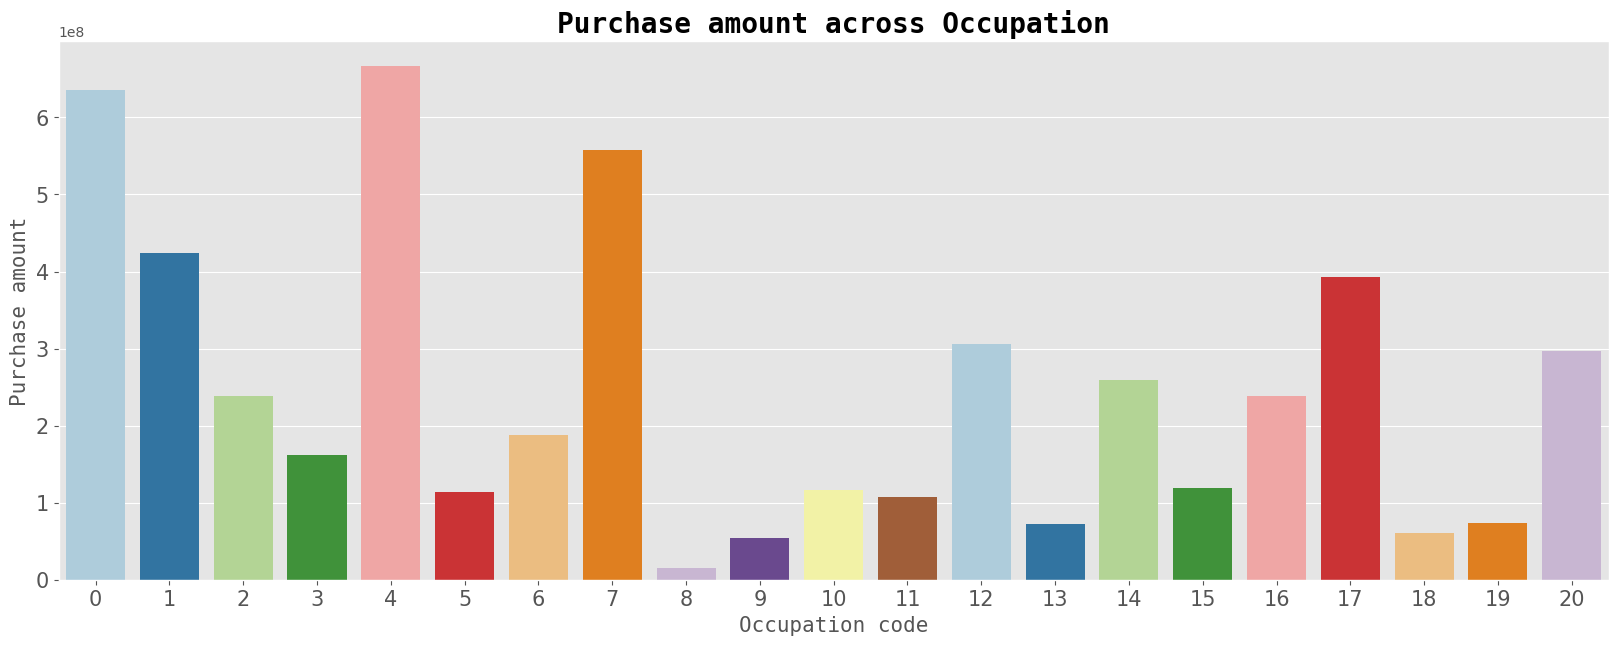

In [31]:
# Creating a barplot of 'Occupation vs Purchase'
# Calculate average purchase amount per occupation
average_purchase_per_occupation = train.groupby('Occupation')['Purchase'].sum()

# Create the barplot using the average values
plt.figure(figsize = (20, 7))
plt.style.use('ggplot')
sns.barplot(x=average_purchase_per_occupation.index, y=average_purchase_per_occupation.values, palette = 'Paired')
plt.title('Purchase amount across Occupation', fontdict = {'fontname' : 'Monospace', 'fontsize' : 20, 'fontweight' : 'bold'})
plt.xlabel('Occupation code', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15})
plt.ylabel('Purchase amount', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15})
plt.tick_params(labelsize = 15)
plt.show()

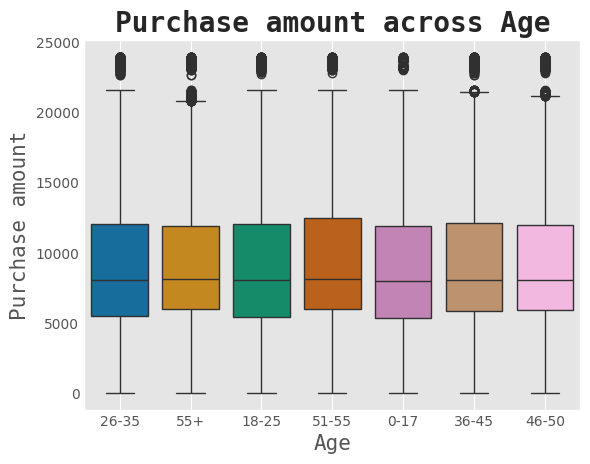

In [42]:
# Creating a boxplot of 'Age vs Purchase'
plt.style.use('ggplot')
sns.boxplot(x=train['Age'], y=train['Purchase'], palette = 'colorblind')
plt.title('Purchase amount across Age', fontdict = {'fontname' : 'Monospace', 'fontsize' : 20, 'fontweight' : 'bold'})
plt.xlabel('Age', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15})
plt.ylabel('Purchase amount', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15})
plt.tick_params(labelsize = 10)
plt.grid()
plt.show()

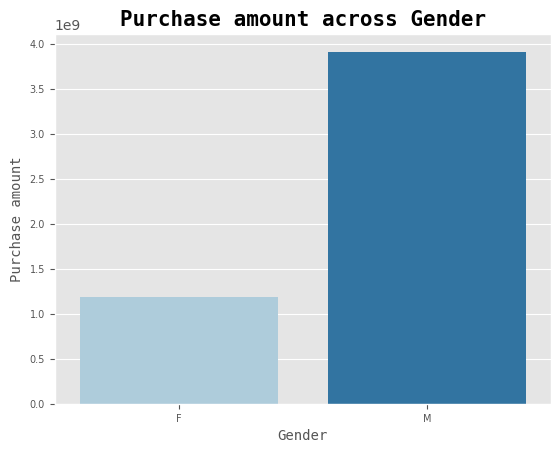

In [35]:
# Creating a barplot of 'Gender vs Purchase'
average_purchase_per_gender = train.groupby('Gender')['Purchase'].sum()
plt.style.use('ggplot')
sns.barplot(x=average_purchase_per_gender.index, y=average_purchase_per_gender.values, palette = 'Paired')
#sns.barplot(x=train['Gender'], y=train['Purchase'])
plt.title('Purchase amount across Gender', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15, 'fontweight' : 'bold'})
plt.xlabel('Gender', fontdict = {'fontname' : 'Monospace', 'fontsize' : 10})
plt.ylabel('Purchase amount', fontdict = {'fontname' : 'Monospace', 'fontsize' : 10})
plt.tick_params(labelsize = 7)

plt.show()

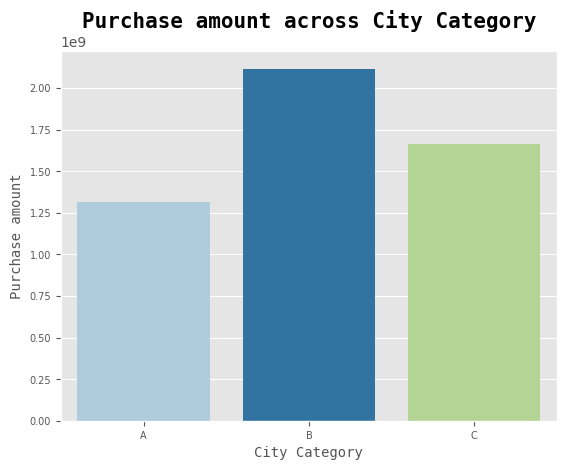

In [36]:
# Creating a barplot of 'City_Category vs Purchase'
average_purchase_per_City = train.groupby('City_Category')['Purchase'].sum()
plt.style.use('ggplot')
sns.barplot(x=average_purchase_per_City.index, y=average_purchase_per_City.values, palette = 'Paired')
#sns.barplot(x=train['City_Category'], y=train['Purchase'])
plt.title('Purchase amount across City Category', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15, 'fontweight' : 'bold'})
plt.xlabel('City Category', fontdict = {'fontname' : 'Monospace', 'fontsize' : 10})
plt.ylabel('Purchase amount', fontdict = {'fontname' : 'Monospace', 'fontsize' : 10})
plt.tick_params(labelsize = 7)
plt.show()

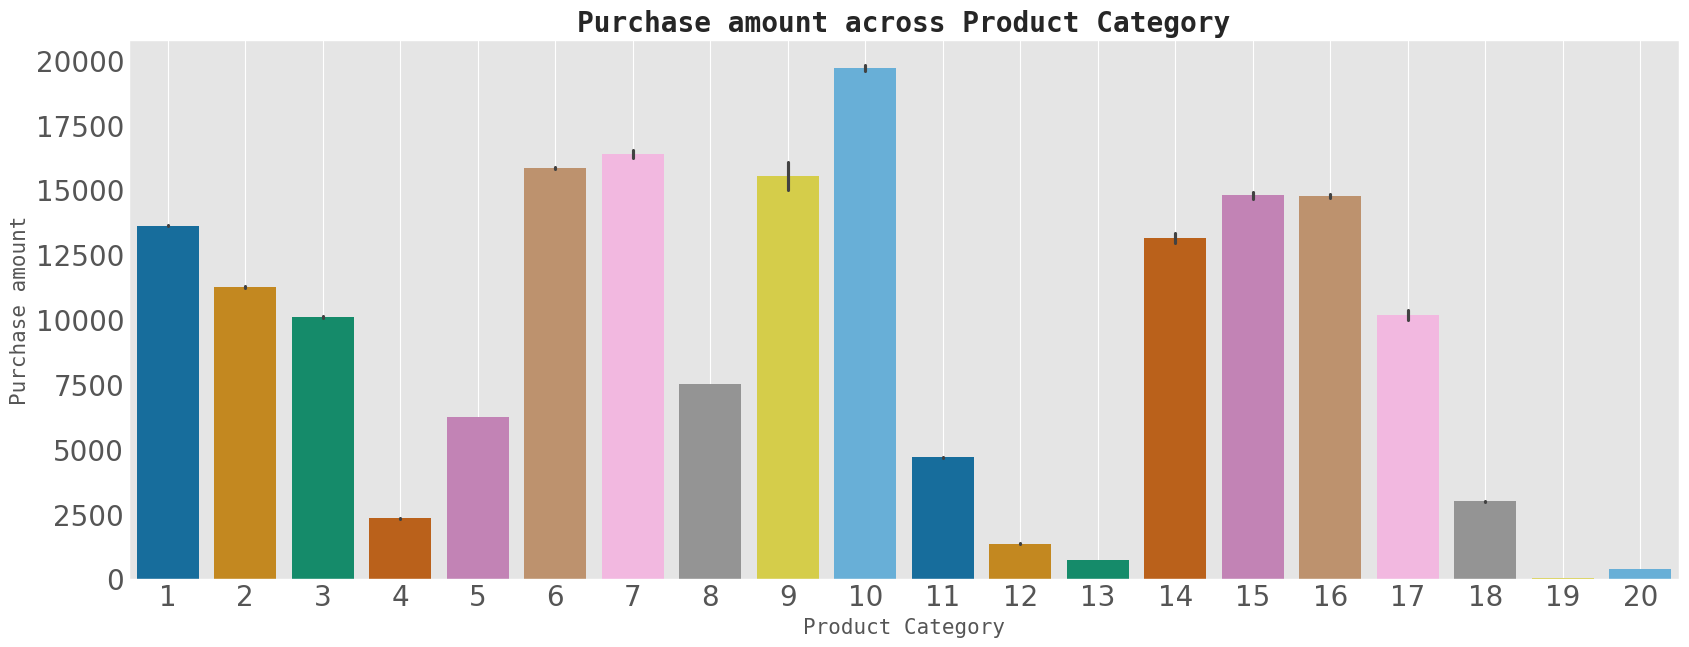

In [43]:
# Creating a barplot of 'Product_Category_1 vs Purchase'
plt.style.use('ggplot')
plt.figure(figsize = (20, 7))
sns.barplot(x=train['Product_Category_1'], y=train['Purchase'], palette = 'colorblind')
plt.title('Purchase amount across Product Category 1', fontdict = {'fontname' : 'Monospace', 'fontsize' : 20, 'fontweight' : 'bold'})
plt.xlabel('Product Category', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15})
plt.ylabel('Purchase amount', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15})
plt.tick_params(labelsize = 20)
plt.grid()
plt.show()

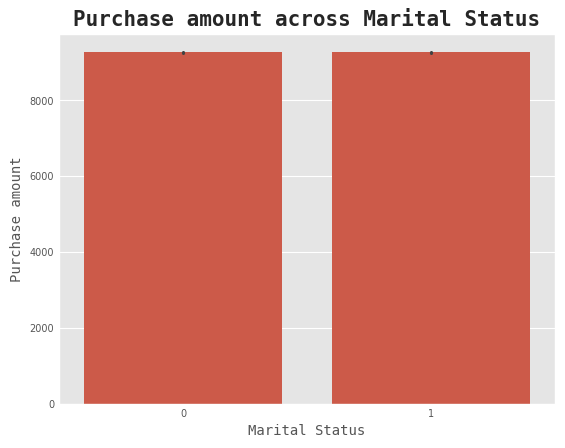

In [44]:
# Creating a barplot of 'Marital Status vs Purchase'
plt.style.use('ggplot')
sns.barplot(x=train['Marital_Status'], y=train['Purchase'])
plt.title('Purchase amount across Marital Status', fontdict = {'fontname' : 'Monospace', 'fontsize' : 15, 'fontweight' : 'bold'})
plt.xlabel('Marital Status', fontdict = {'fontname' : 'Monospace', 'fontsize' : 10})
plt.ylabel('Purchase amount', fontdict = {'fontname' : 'Monospace', 'fontsize' : 10})
plt.tick_params(labelsize = 7)
plt.show()

### 2.3 Multivariate Analysis

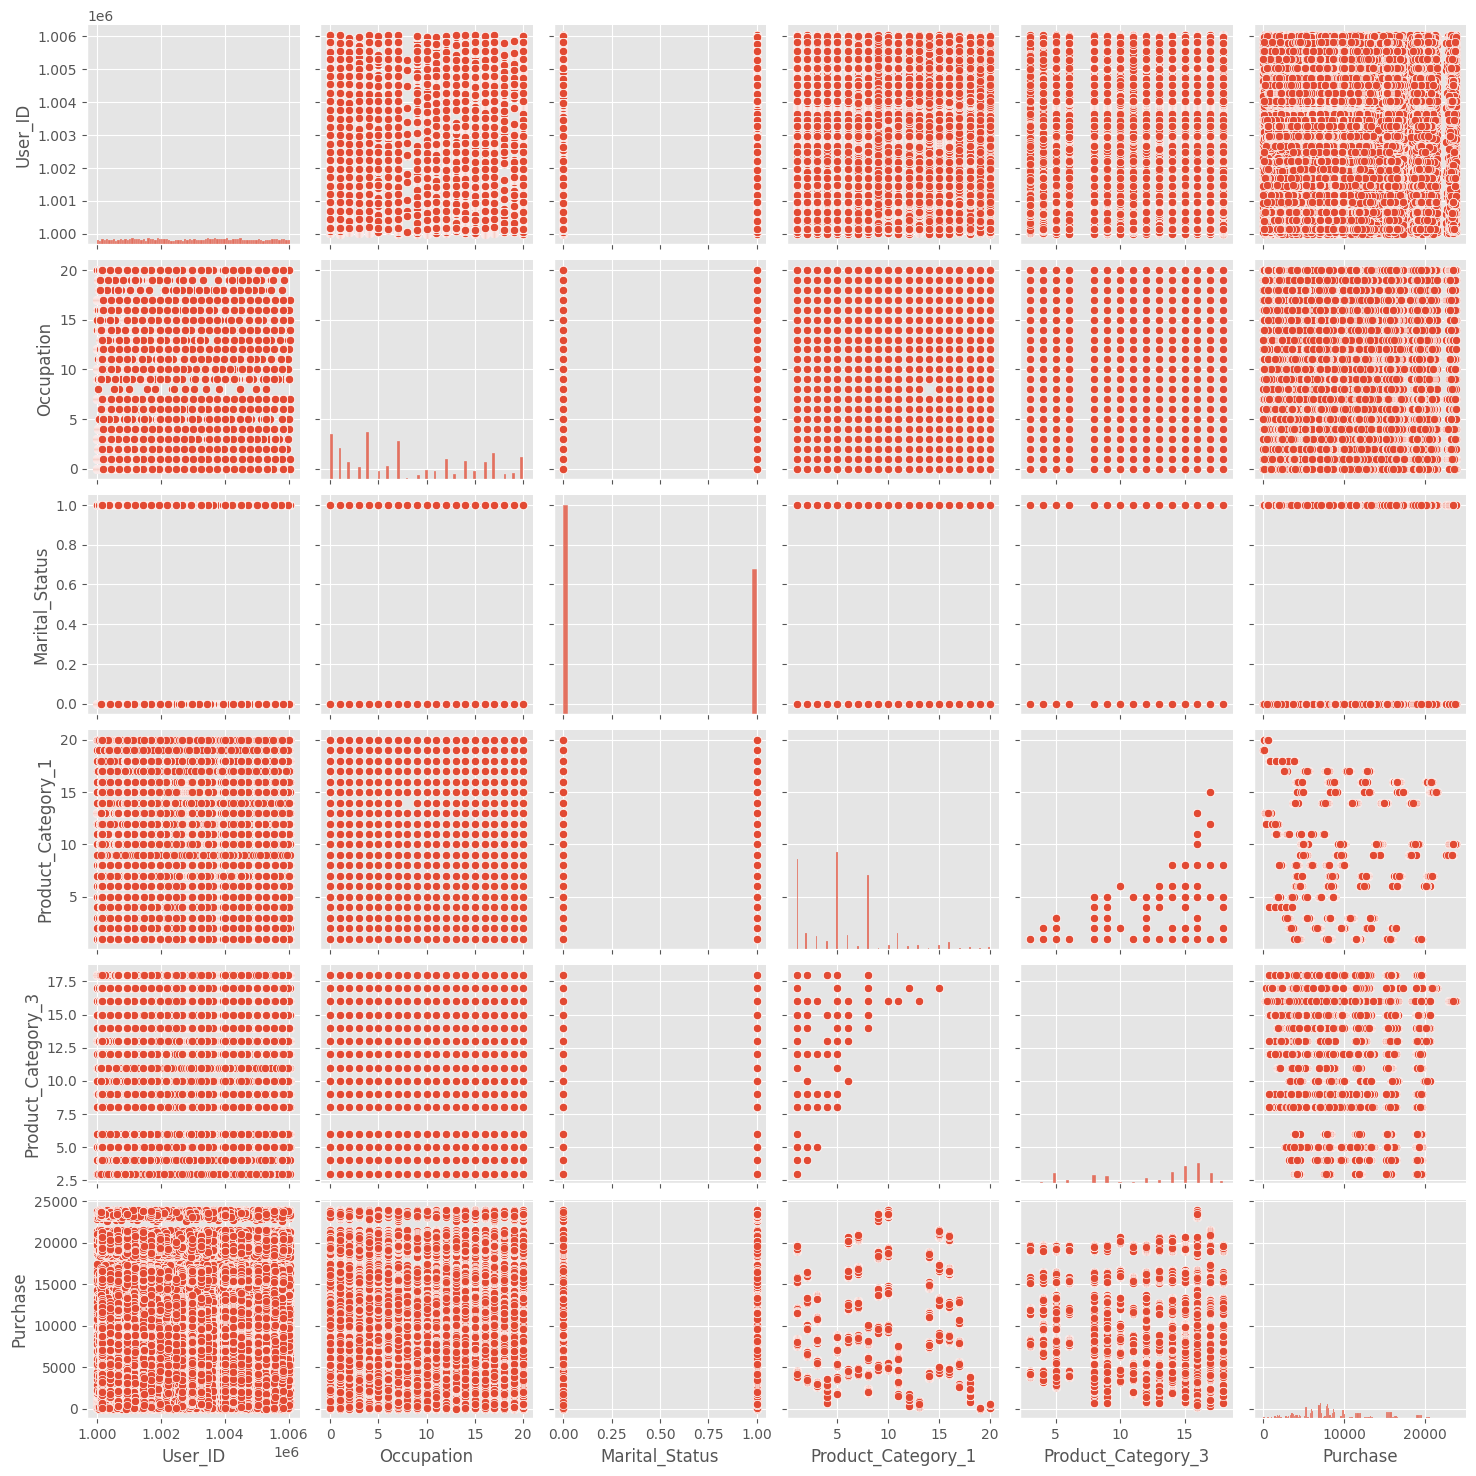

In [33]:
# Creating a Pairplot for all features
plt.style.use('ggplot')
sns.pairplot(train)
plt.show()

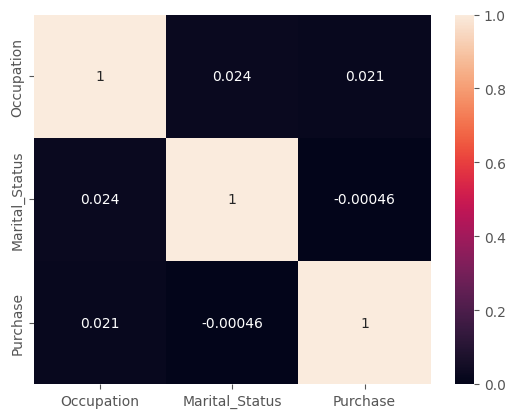

In [35]:
# Creating a heatmap of correlation matrix
sns.heatmap(train[['Occupation','Marital_Status','Purchase']].corr(), annot = True)
plt.show()

<div class="alert alert-block alert-info">

<h3 style="font-family:verdana;"> Observations:</h3>

<ul>
        
<li><p style="font-family:verdana;">
An interesting observation can be made from the gender distribution plot that the number of females was less than the number of men who shopped during Black Friday.
</p></li>    

<li><p style="font-family:verdana;">
From the correlation heatmap, we can observe that the dependent feature 'Purchase' is highly correlated with 'Product_Category_1' and 'Product_Category_2'.
</p></li>    

</ul>

</div>